### Sírio-Libanês COVID-19 - Clinical Data to assess diagnosis
<hr>
<br>



<p align=center>
<img src="https://brasiliaempresas.com.br/wp-content/uploads/2019/02/hospital-sirio-libanes.jpg" width="60%"></p>



#### <b>Context</b>
COVID-19 pandemic impacted the whole world, overwhelming healthcare systems - unprepared for such intense and lengthy request for ICU beds, professionals, personal protection equipment and healthcare resources.
Brazil recorded first COVID-19 case on February 26 and reached community transmission on March 20


<br>
<hr>

<br>

### <b>Goal</b> 

Predict admission to the ICU of confirmed COVID-19 cases.
Based on the data available, is it feasible to predict which patients will need intensive care unit support?
The aim is to provide tertiary and quarternary hospitals with the most accurate answer, so ICU resources can be arranged or patient transfer can be scheduled.


<br>
<hr>



### 1. Frameworks

<br>

In [1]:
!pip install catboost
!pip install hyperopt 
!pip install mlxtend

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

import functools
from hyperopt import hp, fmin, Trials, tpe
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, SelectFromModel
from sklearn.feature_selection import chi2, f_classif
from sklearn.metrics import classification_report, average_precision_score, accuracy_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from mlxtend.classifier import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import xgboost as xgb

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<br>
<hr>
<br>
<br>


### 2. Exploratory Data analysis

Let's explore the variables that most impact, the event that we are trying to predict.

There are 231 features composed in this dataset, we have a high dimension included.

As it is a set of medical data, the data are considered sensitive, because of this many features are already pre-processed and with their names changed, to prevent the data.




<br>
<hr>

In [3]:
# import data 
path = '/content/drive/My Drive/Inteligência Artificial - Colab/Sirio-Libanes/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx'
df = pd.read_excel(path)
df.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.00000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.33913,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.407558,

In [4]:
# shape
print('Rows: {} | Columns: {}'.format(df.shape[0], df.shape[1]))

Rows: 1925 | Columns: 231


As we have already seen, we have many features making the set with a high dimension, something that we must deal with in the feature engineering stage.

<br>

In [5]:
# data types 
df.dtypes

PATIENT_VISIT_IDENTIFIER        int64
AGE_ABOVE65                     int64
AGE_PERCENTIL                  object
GENDER                          int64
DISEASE GROUPING 1            float64
                               ...   
RESPIRATORY_RATE_DIFF_REL     float64
TEMPERATURE_DIFF_REL          float64
OXYGEN_SATURATION_DIFF_REL    float64
WINDOW                         object
ICU                             int64
Length: 231, dtype: object

In [6]:
#  categorical features
cat_cols = df.select_dtypes(include=['object']).columns
num_cols = df.select_dtypes(exclude=['object']).columns
print(df[cat_cols].columns)

Index(['AGE_PERCENTIL', 'WINDOW'], dtype='object')


The dataset description contained the information that there are two categorical features (removing the label) in the set:

* 'AGE_PERCENTIL'
* 'WINDOW'

<br>




Outside the ICU: 1410
Inside the ICU: 515


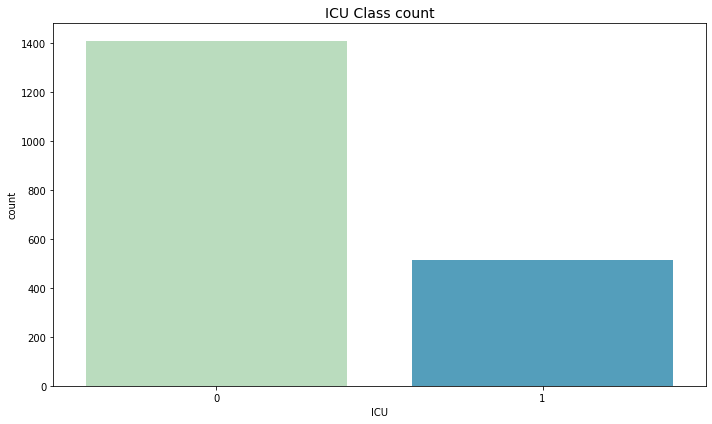

In [7]:
# Label ICU 
plt.figure(figsize=(10,6))
plt.title('ICU Class count', fontsize=14)
sns.countplot(df['ICU'], palette='GnBu')
plt.tight_layout()

# count class 

class_1 = len(df[df['ICU']==1])
class_0 = len(df[df['ICU']==0])

# show 
print('\n')
print('Outside the ICU: {}'.format(class_0))
print('Inside the ICU: {}'.format(class_1))

There are 1925 records in the data set, among the numbers <b> 1410 </b> are outside the ICU and <b> 515 </b> are in ICU beds
There is a certain imbalance of the classes, which we can keep an eye on in the modeling later

<br>

In [8]:
# category aggregation function

def aggregate(df, col, arg, title):
  
  # category values 
  range_1 = len(df[df[col]==arg])
  show = print('{}: {}'.format(title,range_1))
  return show

----- AGE COUNT -----


AGE 10th: 205
AGE 20th: 215
AGE 30th: 205
AGE 40th: 200
AGE 50th: 190
AGE 60th: 185
AGE 70th: 195
AGE 80th: 190
AGE 90th: 155
AGE above 90th: 185


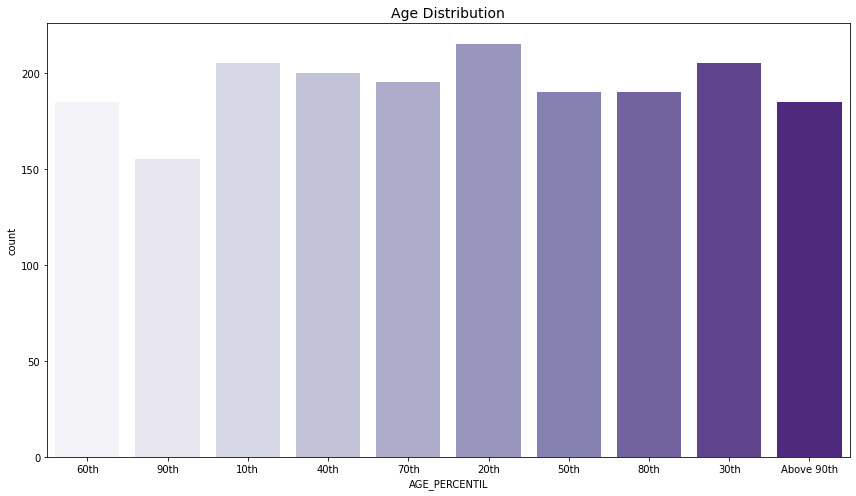

In [9]:
# age distribution
plt.figure(figsize=(12,7))
plt.title('Age Distribution', fontsize=14)
sns.countplot(df['AGE_PERCENTIL'], palette='Purples')
plt.tight_layout()


# Summary ages 
print('----- AGE COUNT -----')
print('\n')
aggregate(df, 'AGE_PERCENTIL', '10th', 'AGE 10th')
aggregate(df, 'AGE_PERCENTIL', '20th', 'AGE 20th')
aggregate(df, 'AGE_PERCENTIL', '30th', 'AGE 30th')
aggregate(df, 'AGE_PERCENTIL', '40th', 'AGE 40th')
aggregate(df, 'AGE_PERCENTIL', '50th', 'AGE 50th')
aggregate(df, 'AGE_PERCENTIL', '60th', 'AGE 60th')
aggregate(df, 'AGE_PERCENTIL', '70th', 'AGE 70th')
aggregate(df, 'AGE_PERCENTIL', '80th', 'AGE 80th')
aggregate(df, 'AGE_PERCENTIL', '90th', 'AGE 90th')
aggregate(df, 'AGE_PERCENTIL', 'Above 90th', 'AGE above 90th')

Ages are formatted on a percentile scale, it is a variable that follows a uniform trend. 

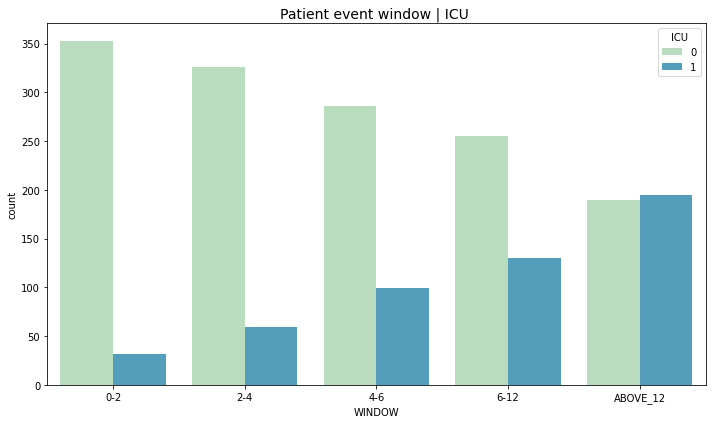

In [10]:
# Patient event window 
plt.figure(figsize=(10,6))
plt.title('Patient event window | ICU ', fontsize=14)
sns.countplot(df['WINDOW'], hue='ICU', data=df, palette='GnBu')
plt.tight_layout()

Looking at the patient's windows (observation) over time in hours, it follows something that we predicted that over time, if the patient already has a strong suspicion on his admission to the hospital, he can be inserted into the ICU on his arrival, or maybe in 0-2 hours, etc., the sooner we can predict whether the patient will need a bed or not, the better.

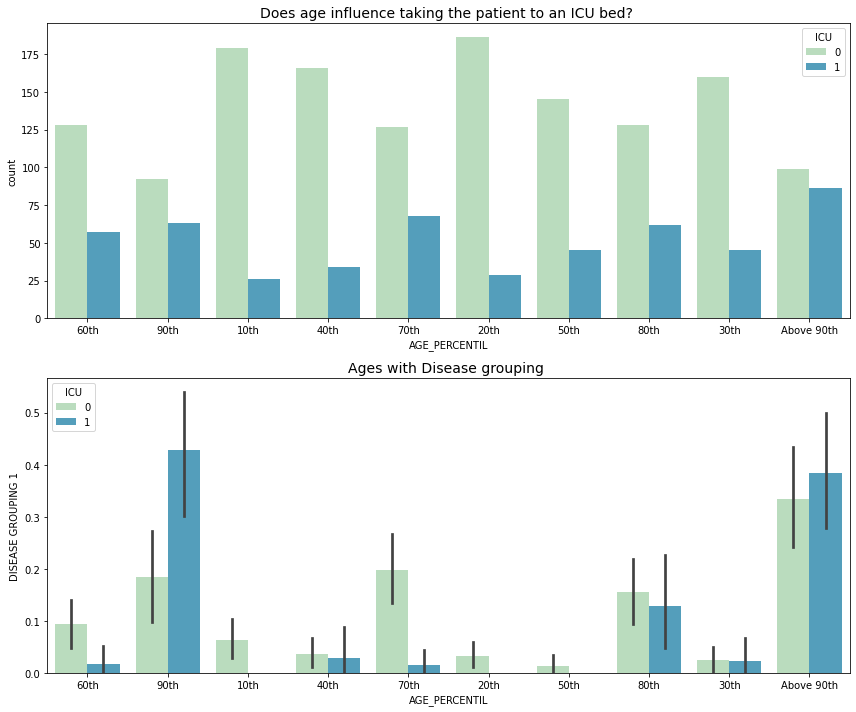

In [11]:
# Does age influence taking the patient to an ICU bed?
plt.figure(figsize=(12,10))
plt.subplot(2,1,1)
plt.title('Does age influence taking the patient to an ICU bed? ', fontsize=14)
sns.countplot(df['AGE_PERCENTIL'], hue='ICU', data=df, palette='GnBu')

print('\n')

# Ages with Disease Grouping 1
plt.subplot(2,1,2)
plt.title('Ages with Disease grouping ', fontsize=14)
sns.barplot(df['AGE_PERCENTIL'], y='DISEASE GROUPING 1', hue='ICU', data=df, palette='GnBu')
plt.tight_layout()

Crossing the <b> DISEASE GROUPING 1 </b> feature with age, traits are also identified, that patients over 90 years old with this first group of diseases, have a high probability of being referred to ICU

<br>

<br>
<hr>
<br>


### Conclusion Exploratory analysis 

<b> An analysis carried out, including a lot of knowledge from doctors and health professionals, already had on the effects of covid-19 in patients. </b>

* Patients over 60 years old have a high probability of reaching the ICU after 12h

* The age points a lot that we must observe much more the patients of high age, that it contains results in the examinations that proved that to some high discrepancy in the examinations.


<b> Warning: As it is a dataset that contains many anonymous features, in a way we do not infer more conclusions due to the health knowledge factor, we made assumptions based on what we classify as the simplest to be analyzed, an analysis done alongside a doctor or professional of health would be of greater gain and strength. </b> 



<hr>
<br>

<br>
<hr>


### 3. Feature engineering 

We will use a simple approach in this step of transforming the features, to later create a general baseline of a single model.

* Missing Values 
* Correct data type

<br>
<hr>
<br>

In [12]:
# view mising values 

def missing_values(data):
    
    # Null total 
    missing_values = data.isnull().sum()
    
    # Order nulls 
    total = missing_values.sort_values(ascending=True)
    
    # Percentage  
    percent = (missing_values / len(data.index)*100).round(2).sort_values(ascending=True)

    table_missing = pd.concat([total, percent], axis=1, keys=['Números de NA', 'Porcentagem de NA'])
  
    return table_missing.tail(10)


missing_values(df)

,Números de NA,Porcentagem de NA
INR_MEDIAN,1104,57.35
INR_MEAN,1104,57.35
INR_MIN,1104,57.35
INR_MAX,1104,57.35
INR_DIFF,1104,57.35
LACTATE_MEDIAN,1104,57.35
LACTATE_MEAN,1104,57.35
LACTATE_MIN,1104,57.35
HEMOGLOBIN_MEAN,1104,57.35
P02_VENOUS_MIN,1104,57.35


In [13]:
# input missing values

imp_numeric = SimpleImputer(missing_values=np.nan, strategy='mean')
num_cols = df.select_dtypes(exclude=['object']).columns 


for col in num_cols:
  if df[col].isnull().sum() > 0:
    df[col] = imp_numeric.fit_transform(df[[col]])
  else:
    pass

In [14]:
# handling categorical AGE_PERCENTIL 

def cat_percentil(percentil):
    if percentil == "Above 90th":
        return(100)
    else:
        return(int("".join(c for c in str(percentil) if c.isdigit())))


# checking AGE_PERCENTIL 
df['AGE_PERCENTIL'] = df['AGE_PERCENTIL'].apply(lambda x: cat_percentil(x))
df['AGE_PERCENTIL'].isnull().sum()

0

In [15]:
# handling categorical WINDOW 

def cat_window(window):
    if window == "ABOVE_12":
        return(13)
    else:
        return(int((window.split("-")[1])))


df['WINDOW'] = df['WINDOW'].apply(lambda x: cat_window(x))
df['WINDOW'].isnull().sum()

0

In [16]:
# remove ID 
df.drop('PATIENT_VISIT_IDENTIFIER', axis=1, inplace=True)

<br>
<hr>
<br>

### 4. Baseline 


We will develop a baseline, a model that will serve as a parameter in relation to the metrics, through it we will interpret how the later models will be performing compared to it.

Let's apply a simple logistic regression, and see the performance of the model.

<br>

<b>WARNING:</b> As already seen in the exploratory analysis part, the metrics with the greatest focus will be <b> Precision, Recall and AUC </b> as we have already verified that there is a certain class imbalance, and we want the model to learn to identify a separation in patients who need ICU or not and those who in fact need immediate ICU referral.

<br>
<hr>
<br>

In [17]:
# features | label
X_baseline = df.drop('ICU', axis=1)
y_baseline = df['ICU']


# spliting 
X_train_baseline, X_test_baseline, y_train_baseline, y_test_baseline = train_test_split(X_baseline,y_baseline, test_size=0.30, random_state=42)


# Standard 
scaler = StandardScaler()
X_train_baseline = scaler.fit_transform(X_train_baseline)
X_test_baseline = scaler.transform(X_test_baseline)


# Logistic regression 
baseline = LogisticRegression(random_state=42)
baseline.fit(X_train_baseline, y_train_baseline)
y_pred_baseline = baseline.predict(X_test_baseline)
y_proba_baseline = baseline.predict_proba(X_test_baseline)[:,1]
print(classification_report(y_test_baseline, y_pred_baseline))


# Summary 
print('\n')
print('--------- Baseline Summary ------------')
print('\n')
print('Precision: {}'.format(round(precision_score(y_test_baseline, y_pred_baseline),2)))
print('Recall: {}'.format(round(recall_score(y_test_baseline, y_pred_baseline),2)))
print('AUC: {}'.format(round(roc_auc_score(y_test_baseline, y_proba_baseline),2)))
print('Precision-Recall: {}'.format(round(average_precision_score(y_test_baseline, y_proba_baseline),2)))

              precision    recall  f1-score   support

           0       0.84      0.96      0.90       413
           1       0.84      0.56      0.67       165

    accuracy                           0.84       578
   macro avg       0.84      0.76      0.78       578
weighted avg       0.84      0.84      0.83       578



--------- Baseline Summary ------------


Precision: 0.84
Recall: 0.56
AUC: 0.84
Precision-Recall: 0.76


<br>

Our baseline was made with a very simple logistic regression model and presented the results above, starting from here we will guide our next models comparing the results with this baseline.



<hr>
<br>


<br>

### 5. Feature Selection

We will apply a Feature selection technique, which will help to reduce the number of features helping to contain the complexity of the model.


The criteria for selecting the features used will be through the <b> ANOVA F-Value </b> is a way to see which features are most statistically relevant.




<br>

<b> What is ANOVA? </b>


Analysis of Variance or ANOVA is a procedure used to compare the distribution of three or more groups in independent samples.


its associated estimation procedure (such as "variation" between groups) used to analyze differences between group means in a sample.

  ANOVA is based on the law of total variation, in which the variation observed in a specific variable is divided into components attributable to different sources of variation. In its simplest form, ANOVA provides a statistical test to determine whether two or more population averages are equal and, therefore, generalizes the t-test in addition to two means.


more about ANOVA: 
* https://www.youtube.com/watch?v=CS_BKChyPuc
* https://www.statisticshowto.com/probability-and-statistics/hypothesis-testing/anova/



<br> 

In the Scikit-learn package it is available in the feature_selection module and is called <b> f_classif </b>

<br>
<hr>
<br>

In [18]:
# feature selector function 

def feature_selection(k_value=2, name='RandomForest', model=XGBClassifier(random_state=42)):

  # number features 
  k=k_value 
  f_class = functools.partial(f_classif)


  # features | label 
  X = df.drop('ICU', axis=1)
  y = df['ICU']


  # spliting 
  X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)


  # filter  
  seletor = SelectKBest(score_func=f_class, k=k)
  X_train2 = seletor.fit_transform(X_train, y_train)
  X_test2 = seletor.transform(X_test)


  # Random Forest  
  mdl = model
  mdl.fit(X_train2, y_train)
  y_pred = mdl.predict(X_test2)
  y_proba = mdl.predict_proba(X_test2)[:,1]


  # metrics 
  accuracy = round(accuracy_score(y_test, y_pred),2)
  precision = round(precision_score(y_test, y_pred),2)
  recall = round(recall_score(y_test, y_pred),2)
  precision_recall = round(average_precision_score(y_test, y_proba),2)
  auc = round(roc_auc_score(y_test, y_proba),2)
  

  print('K: {} | Acurácia: {}'.format(k, accuracy))
  print('K: {} | Precision: {}'.format(k, precision))
  print('K: {} | Recall: {}'.format(k, recall))
  print('K: {} | Precision-Recall: {}'.format(k, precision_recall))
  print('K: {} | AUC: {}'.format(k, auc))
  print('\n')
  print('\n')

  mask = seletor.get_support()
  best_features = X.columns[mask]
  print('----- Best {} features {} --------'.format(k, name))
  print('\n')
  print(best_features)

In [19]:
# Features for XGBoost 
feature_selection(k_value=50, name='XGBoost', model=XGBClassifier(random_state=42))

K: 50 | Acurácia: 0.85
K: 50 | Precision: 0.81
K: 50 | Recall: 0.63
K: 50 | Precision-Recall: 0.82
K: 50 | AUC: 0.89




----- Best 50 features XGBoost --------


Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATURA

<br>
<hr>
<br>

In [20]:
# Features for LightGBM
feature_selection(k_value=50, name='LightGBM', model=XGBClassifier(random_state=42))

K: 50 | Acurácia: 0.85
K: 50 | Precision: 0.81
K: 50 | Recall: 0.63
K: 50 | Precision-Recall: 0.82
K: 50 | AUC: 0.89




----- Best 50 features LightGBM --------


Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATUR

<br>
<hr>
<br>

In [21]:
# Features for CatBoost
feature_selection(k_value=50, name='CatBoost', model=CatBoostClassifier(iterations=100,
                             loss_function='Logloss',
                             task_type='CPU',
                             random_state=42,
                             verbose=False))

K: 50 | Acurácia: 0.87
K: 50 | Precision: 0.86
K: 50 | Recall: 0.64
K: 50 | Precision-Recall: 0.82
K: 50 | AUC: 0.89




----- Best 50 features CatBoost --------


Index(['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATUR

<br>
<hr>
<br>
<br>


### 6. Tuning Hyperparameters 


The approach that we are going to apply for Optimizing hyperparameters is <b> Bayesian Optimization </b> a robust technique that has greater gains in converging the search for the best value of a hyperparameter.


Framework that provides the technique is Hyperopt

For a bigger study, about Bayesian Optimization and what is the mathematics behind:

* https://towardsdatascience.com/an-introductory-example-of-bayesian-optimization-in-python-with-hyperopt-aae40fff4ff0

* https://medium.com/spikelab/hyperparameter-optimization-using-bayesian-optimization-f1f393dcd36d





<br>
<hr>
<br>

#### Tuning XGBoost

<br>

In [22]:
# TOP 50 features XGBoost 
xgb_columns = df[['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATURATION_MAX', 'BLOODPRESSURE_DIASTOLIC_DIFF',
       'BLOODPRESSURE_SISTOLIC_DIFF', 'HEART_RATE_DIFF',
       'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
       'BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_DIFF_REL',
       'HEART_RATE_DIFF_REL', 'RESPIRATORY_RATE_DIFF_REL',
       'TEMPERATURE_DIFF_REL', 'OXYGEN_SATURATION_DIFF_REL', 'WINDOW', 'ICU']]


X = xgb_columns.drop('ICU', axis=1)
y = df['ICU']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

mdl = XGBClassifier(random_state=42)
mdl.fit(X_train, y_train)
y_pred = mdl.predict(X_test)
y_proba = mdl.predict_proba(X_test)[:,1]


# objective function 
def objective(params):
  return -average_precision_score(y_test, y_proba)

In [23]:
#probability of distribution of parameters

spaces_xgboost = {'n_estimators': hp.randint('n_estimators', 1200),
          'learning_rate': hp.loguniform('learning_rate', 1e-5, 1e-1),
          'max_depth': hp.randint('max_depth', 30),
          'min_child_weight': hp.uniform('min_child_weight', 0,20),
          'reg_lambda': hp.uniform('reg_lambda', 0.001, 3),
          'reg_alpha': hp.uniform('reg_alpha', 0.001, 3),
          'gamma': hp.uniform('gamma', 0,10),
          'max_delta_step': hp.uniform('max_delta_step', 0, 10),
          'max_leaves': hp.randint('max_leaves', 30),
          'colsample_bytree': hp.uniform('colsample_bytree', 0.1,1.0),
          'colsample_bylevel': hp.uniform('colsample_bylevel', 0.1, 1.0),
          'scale_pos_weight': hp.randint('scale_pos_weight', 10)}

In [24]:
# Bayesian Optimization 
trials = Trials()
xgboost_tuning = fmin(objective, spaces_xgboost, algo=tpe.suggest, max_evals=100, trials=trials, verbose=1)

100%|██████████| 100/100 [00:02<00:00, 39.87it/s, best loss: -0.821110270865465]


In [25]:
# best params 
xgboost_tuning

{'colsample_bylevel': 0.7534683750845167,
 'colsample_bytree': 0.17649326256281112,
 'gamma': 5.893978704207199,
 'learning_rate': 1.0833495977812617,
 'max_delta_step': 2.557083528493642,
 'max_depth': 21,
 'max_leaves': 25,
 'min_child_weight': 1.256311419355165,
 'n_estimators': 808,
 'reg_alpha': 1.1758146990672385,
 'reg_lambda': 1.7490422694511372,
 'scale_pos_weight': 2}

In [26]:
# XGBoost tuning
xgboost = XGBClassifier(**xgboost_tuning, random_state=42)
xgboost.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
y_proba = xgboost.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))


# XGBoost summary 
print('\n')
print('AUC: {}'.format(round(roc_auc_score(y_test, y_proba),2)))
print('Precision-Recall: {}'.format(round(average_precision_score(y_test, y_proba),2)))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       413
           1       0.71      0.72      0.71       165

    accuracy                           0.83       578
   macro avg       0.80      0.80      0.80       578
weighted avg       0.83      0.83      0.83       578



AUC: 0.87
Precision-Recall: 0.76


<br>
<hr>
<br>

#### Tuning LightGBM

<br>

In [27]:
# TOP 50 features LightGBM 
lightgbm_columns = df[['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATURATION_MAX', 'BLOODPRESSURE_DIASTOLIC_DIFF',
       'BLOODPRESSURE_SISTOLIC_DIFF', 'HEART_RATE_DIFF',
       'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
       'BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_DIFF_REL',
       'HEART_RATE_DIFF_REL', 'RESPIRATORY_RATE_DIFF_REL',
       'TEMPERATURE_DIFF_REL', 'OXYGEN_SATURATION_DIFF_REL', 'WINDOW', 'ICU']]


X = lightgbm_columns.drop('ICU', axis=1)
y = df['ICU']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)


# objective function 
def objective(params):
  return -average_precision_score(y_test, y_proba)

In [28]:
#probability of distribution of parameters

spaces_lightgbm = {'n_estimators': hp.randint('n_estimators', 1000),
          'num_leaves': hp.randint('num_leaves', 100),
          'learning_rate': hp.loguniform('learning_rate', 1e-5, 1e-1),
          'max_depth': hp.randint('max_depth', 30),
          'min_child_samples': hp.uniform('min_child_samples', 0,20),
          'lambda_l1': hp.uniform('lambda_l1', 0.001, 3),
          'lambda_l2': hp.uniform('lambda_l2', 0.001, 3),
          'min_data_in_leaf': hp.randint('min_data_in_leaf', 40)}

In [29]:
# Bayesian Optimization 
trials = Trials()
lightgbm_tuning = fmin(objective, spaces_lightgbm, algo=tpe.suggest, max_evals=100, trials=trials, verbose=1)

100%|██████████| 100/100 [00:01<00:00, 69.62it/s, best loss: -0.7643681394177468]


In [30]:
# best params LightGBM 
lightgbm_tuning

{'lambda_l1': 1.8634504574130015,
 'lambda_l2': 0.814995014929885,
 'learning_rate': 1.0965527991673774,
 'max_depth': 22,
 'min_child_samples': 9.33960590799101,
 'min_data_in_leaf': 24,
 'n_estimators': 286,
 'num_leaves': 53}

In [31]:
# LightGBM tuning
lightgbm = LGBMClassifier(**lightgbm_tuning, seed=42)
lightgbm.fit(X_train, y_train)
y_pred = xgboost.predict(X_test)
y_proba = lightgbm.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))


# LightGBM summary 
print('\n')
print('AUC: {}'.format(round(roc_auc_score(y_test, y_proba),2)))
print('Precision-Recall: {}'.format(round(average_precision_score(y_test, y_proba),2)))

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       413
           1       0.71      0.72      0.71       165

    accuracy                           0.83       578
   macro avg       0.80      0.80      0.80       578
weighted avg       0.83      0.83      0.83       578



AUC: 0.89
Precision-Recall: 0.79


<br>
<hr>
<br>

### Tuning CatBoost 

In [32]:
# TOP 50 features CatBoost  
catboost_columns = df[['AGE_ABOVE65', 'AGE_PERCENTIL', 'ALBUMIN_MIN', 'ALBUMIN_MAX',
       'BE_ARTERIAL_MEDIAN', 'BE_ARTERIAL_MEAN', 'BE_ARTERIAL_MIN',
       'BE_ARTERIAL_MAX', 'BE_VENOUS_MEDIAN', 'BE_VENOUS_MEAN',
       'BE_VENOUS_MIN', 'BE_VENOUS_MAX', 'HEMATOCRITE_MEDIAN',
       'HEMATOCRITE_MEAN', 'HEMATOCRITE_MIN', 'HEMATOCRITE_MAX',
       'HEMOGLOBIN_MEDIAN', 'HEMOGLOBIN_MEAN', 'HEMOGLOBIN_MIN',
       'HEMOGLOBIN_MAX', 'LACTATE_MEDIAN', 'LACTATE_MEAN', 'LACTATE_MIN',
       'LACTATE_MAX', 'LEUKOCYTES_MEDIAN', 'LEUKOCYTES_MEAN', 'LEUKOCYTES_MIN',
       'LEUKOCYTES_MAX', 'BLOODPRESSURE_DIASTOLIC_MEAN',
       'RESPIRATORY_RATE_MEAN', 'BLOODPRESSURE_DIASTOLIC_MEDIAN',
       'RESPIRATORY_RATE_MEDIAN', 'BLOODPRESSURE_DIASTOLIC_MIN',
       'TEMPERATURE_MIN', 'BLOODPRESSURE_SISTOLIC_MAX', 'RESPIRATORY_RATE_MAX',
       'OXYGEN_SATURATION_MAX', 'BLOODPRESSURE_DIASTOLIC_DIFF',
       'BLOODPRESSURE_SISTOLIC_DIFF', 'HEART_RATE_DIFF',
       'RESPIRATORY_RATE_DIFF', 'TEMPERATURE_DIFF', 'OXYGEN_SATURATION_DIFF',
       'BLOODPRESSURE_DIASTOLIC_DIFF_REL', 'BLOODPRESSURE_SISTOLIC_DIFF_REL',
       'HEART_RATE_DIFF_REL', 'RESPIRATORY_RATE_DIFF_REL',
       'TEMPERATURE_DIFF_REL', 'OXYGEN_SATURATION_DIFF_REL', 'WINDOW', 'ICU']]



X = catboost_columns.drop('ICU', axis=1)
y = df['ICU']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)



# objective function 
def objective(params):
  return -average_precision_score(y_test, y_proba)

In [33]:
#probability of distribution of parameters

spaces_catboost = {'iterations': hp.randint('iterations', 1000),
                  'learning_rate': hp.loguniform('learning_rate', 1e-5, 1e-1),
                  'depth': hp.randint('depth', 10),
                  'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.01, 3),
                  'bagging_temperature': hp.randint('bagging_temperature', 20),
                  'random_strength': hp.loguniform('random_strength', 1e-9, 10),
                  'scale_pos_weight': hp.uniform('scale_pos_weight', 0.01, 1.0)
                  }

In [34]:
# Bayesian Optimization 
trials = Trials()
catboost_tuning = fmin(objective, spaces_catboost, algo=tpe.suggest, max_evals=100, trials=trials, verbose=1)

100%|██████████| 100/100 [00:01<00:00, 70.22it/s, best loss: -0.7856801218271303]


In [35]:
# best params Catboost 
catboost_tuning

{'bagging_temperature': 13,
 'depth': 7,
 'iterations': 256,
 'l2_leaf_reg': 1.4946599504685933,
 'learning_rate': 1.0064562567631183,
 'random_strength': 1.377931415132763,
 'scale_pos_weight': 0.16417851918992257}

In [36]:
# Catboost Tuning 
catboost = CatBoostClassifier(**catboost_tuning,
                         random_seed=42,
                         eval_metric='Precision',
                         task_type= 'CPU',
                         verbose=False)
catboost.fit(X_train, y_train)
y_pred = catboost.predict(X_test)
y_proba = catboost.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))

# CatBoost summary 
print('\n')
print('AUC: {}'.format(round(roc_auc_score(y_test, y_proba),2)))
print('Precision-Recall: {}'.format(round(average_precision_score(y_test, y_proba),2)))

learning rate is greater than 1. You probably need to decrease learning rate.


              precision    recall  f1-score   support

           0       0.84      0.97      0.90       413
           1       0.89      0.55      0.68       165

    accuracy                           0.85       578
   macro avg       0.87      0.76      0.79       578
weighted avg       0.86      0.85      0.84       578



AUC: 0.85
Precision-Recall: 0.77


<br>
<hr>
<br>
<br>

### 7. Validation 


In this step we will create a robust cross-validation for each Gradient Boosting.

We chose to apply the <b> StratifiedKFold </b> which, unlike Sklearn's standard KFold, it maintains the proportion of the classes in each fold allowing no class imbalance in the validation.


<br>
<hr>
<br>

In [37]:
# Cross validation function 

def cross_validation(X, model, name, cv=5):
  
  # features | class 
  X = X
  y = df['ICU']

  # results metrics 
  accuracy = []
  precision = []
  recall = []
  auc = []
  precision_recall = []

  # StratifiedKFold 
  KFold = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

  for train_index, test_index in KFold.split(X,y):
    # Train and Test 
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    print('Train: {}'.format(X_train.shape))
    print('Test: {}'.format(X_test.shape))
    print('\n')

    # Gradient boosting 
    mdl = model
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    y_proba = mdl.predict_proba(X_test)[:,1]


    # metrics 
    acc_results = round(accuracy_score(y_test, y_pred),5)
    precision_results = round(precision_score(y_test, y_pred),2)
    recall_results = round(recall_score(y_test, y_pred),2)
    auc_results = round(roc_auc_score(y_pred, y_proba),2)
    pr_results = round(average_precision_score(y_test, y_proba),2)




  # append results 
  accuracy.append(acc_results)
  precision.append(precision_results)
  recall.append(recall_results)
  auc.append(auc_results)
  precision_recall.append(pr_results)


  # show metrics 
  print('\n')
  print('----- Validation {} -----'.format(name))
  print('Accuracy: {}'.format(np.mean(accuracy)))
  print('Precision: {}'.format(np.mean(precision)))
  print('Recall: {}'.format(np.mean(recall)))
  print('AUC: {}'.format(np.mean(auc)))
  print('Precision-Recall: {}'.format(np.mean(precision_recall)))  

In [38]:
# CV XGBoost 
cross_validation(X=xgb_columns.drop('ICU', axis=1), model=xgboost, name='XGBoost',cv=5)

Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)




----- Validation XGBoost -----
Accuracy: 0.86234
Precision: 0.76
Recall: 0.72
AUC: 1.0
Precision-Recall: 0.83


In [39]:
# CV LightGBM 
cross_validation(X=lightgbm_columns.drop('ICU', axis=1), model=lightgbm, name='LightGBM',cv=5)

Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)


Train: (1540, 50)
Test: (385, 50)




----- Validation LightGBM -----
Accuracy: 0.88052
Precision: 0.81
Recall: 0.72
AUC: 1.0
Precision-Recall: 0.83


In [40]:
# CV CatBoost 
cross_validation(X=catboost_columns.drop('ICU', axis=1), model=catboost, name='CatBoost',cv=5)

Train: (1540, 50)
Test: (385, 50)




learning rate is greater than 1. You probably need to decrease learning rate.


Train: (1540, 50)
Test: (385, 50)




learning rate is greater than 1. You probably need to decrease learning rate.


Train: (1540, 50)
Test: (385, 50)




learning rate is greater than 1. You probably need to decrease learning rate.


Train: (1540, 50)
Test: (385, 50)




learning rate is greater than 1. You probably need to decrease learning rate.


Train: (1540, 50)
Test: (385, 50)




learning rate is greater than 1. You probably need to decrease learning rate.




----- Validation CatBoost -----
Accuracy: 0.87013
Precision: 0.86
Recall: 0.61
AUC: 1.0
Precision-Recall: 0.83


<br>
<hr>
<br>

<br>
<hr>
<br>
<br>


### 8. Stacking Gradient Boosting


Ensemble methods are commonly used to boost predictive accuracy by combining the predictions of multiple machine learning models. The traditional wisdom has been to combine so-called “weak” learners. However, a more modern approach is to create an ensemble of a well-chosen collection of strong yet diverse models.

<br>

Let's create a stacking set with three Gradient Boosting algorithms as an experiment.

<b> Stacking</b>:

* XGBoost 
* LightGBM
* CatBoost 

<br>
<hr>
<br>

In [41]:
# Three models 
clf1 = xgboost
clf2 = lightgbm
clf3 = catboost 

# meta-classifier 
meta_clf = LogisticRegression(random_state=42)

# Stacking 
stack = StackingClassifier(classifiers=[clf1, clf2, clf3],
                           use_probas=True,
                           average_probas=False,
                          meta_classifier=meta_clf)

In [42]:
stack.fit(X_train, y_train)
y_pred = stack.predict(X_test)
y_proba = stack.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print('\n')

print('AUC: {}'.format(round(roc_auc_score(y_test, y_proba),2)))
print('Precision-Recall: {}'.format(round(average_precision_score(y_test, y_proba),4)))

learning rate is greater than 1. You probably need to decrease learning rate.


              precision    recall  f1-score   support

           0       0.87      0.95      0.91       413
           1       0.83      0.65      0.73       165

    accuracy                           0.86       578
   macro avg       0.85      0.80      0.82       578
weighted avg       0.86      0.86      0.86       578



AUC: 0.9
Precision-Recall: 0.7998


<br>
<hr>
<br>


### <b>Conclusion</b> 

This notebook from the beginning we elaborated the modeling, aiming to maximize the <b> Precision-Recall </b> of the model that we consider to be the most important task of this problem, to identify patients who need a bed in the ICU.

<br>

As we saw that there were many features, we tried to reduce them at the discretion of an ANOVA test for the features that the test considered statistically significant, and we selected only 50 to reduce the complexity of the model (in another notebook that we did the part with only the feature selection , the best number of features for the models was 165 features, we chose to use only 50 to reduce complexity)

<br>

Applying three boosting algorithms, we expected better results in relation to the metrics, tuning the hyperparameters and using precision-recall as an objective function, there was also little impact on the predictive power of the models.

<br>

#### <b> Hypothesis suggestions </b>


We formulate some hypotheses to be tested in the future as possible best solutions.

<br>

* <b>Feature engineering:</b> Investing more time in this step, certainly because they are largely anonymous, makes it difficult to understand, and ends up limiting some attempts due to knowledge about the data, a better treatment with features can be promising (let's explore) the amount of missing values and how to allocate them is very delicate.

<br>

* <b>Amount of data:</b>analyzing the dataset carefully we find that there are 1925 lines, but that a patient is present in 5 lines and grouping them all, the base has about <b> 385 </b> patients that less than 250 of them went to the ICU, in in addition to the low amount of data, we can also explore resampling techniques to balance the base.


<br>


* <b> H2o AutoML: </b> Finally, another solution, which we can also try is to use the AutoML tool called <b> H2o </b> which has high performance in several solutions on the market, it had the Python library and also the <b> H2o AI driverless platform </b> where everything is done automatically, is a possibility to be considered.


<br> 


We thank you for opening and making the data available, and we will continue looking for other ways to solve this problem, immediately our ML model Stacking has <b> Precision-Recall: 80% </b> and it is our solution so far.


<br>
<hr>
<br>